In [1]:
import os
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import issparse, csr
import scanpy as sc

import torch
from torch.utils.data import Dataset
from torch.utils.data.sampler import Sampler
from torch.utils.data import DataLoader

from anndata import AnnData
import anndata as ad
import scanpy as sc
from sklearn.preprocessing import maxabs_scale, MaxAbsScaler

import math
from glob import glob

import warnings

# 忽略警告
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import random
seed = 666
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [3]:
## 读取数据
adata = sc.read_loom('./panc8.loom',sparse=False)  #Load cell line dataset(-> count data). 
# celltype = adata.obs['celltype']

/home/zhouwg/anaconda3/envs/PyTorch/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/zhouwg/anaconda3/envs/PyTorch/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/home/zhouwg

In [4]:
adata.obs['batch'].value_counts()

batch
indrop        8569
smartseq2     2394
celseq2       2285
celseq        1004
fluidigmc1     638
Name: count, dtype: int64

In [6]:
# 非并行方式
from ccvae.step1_partition import run_partition

import time
start_time = time.time()
batch_key = 'batch'  # 批次信息保存在 adata.obs['batch'] 列中
num_iterations = 1 # number of re-sampling 
ccPairs_adata, rest_adata = run_partition(adata, batch_key, num_iterations,
                                          sample_ratio=1, drop_last=True, omics='scRNA',
                                          nHVGs=2000, npcs=20, singular_ratio=0.9, canonical_ratio=0.9, 
                                          metric='euclidean', k1=50, k2=20, 
                                          normalization=True, min_genes=200, min_cells=3,
                                          Matchability=False, seed = seed, verbose=False)
print("Running time is ", (time.time()-start_time)/60)

Preparing to calculating Anchor and Query Pairs...
Iteration 1/1
Data preprocess of reference...
Data preprocess of query...
PreProcess Done.
Iteration 1/1
Data preprocess of reference...
Data preprocess of query...
PreProcess Done.
Iteration 1/1
Data preprocess of reference...
Data preprocess of query...
PreProcess Done.
Iteration 1/1
Data preprocess of reference...
Data preprocess of query...
PreProcess Done.
Iteration 1/1
Data preprocess of reference...
Data preprocess of query...
PreProcess Done.
Iteration 1/1
Data preprocess of reference...
Data preprocess of query...
PreProcess Done.
Iteration 1/1
Data preprocess of reference...
Data preprocess of query...
PreProcess Done.
Iteration 1/1
Data preprocess of reference...
Data preprocess of query...
PreProcess Done.
Iteration 1/1
Data preprocess of reference...
Data preprocess of query...
PreProcess Done.
Iteration 1/1
Data preprocess of reference...
Data preprocess of query...
PreProcess Done.
Finishing calculating cell-cell Pairs..

### Run  ccVAE with HVGs

In [7]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [8]:
condition_key = 'batch'
cell_type_key = 'celltype'

ccvae_epochs = 500
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

### Preparing the data for ccVAE model

In [9]:
from ccvae.step2_ccVAE_utils import prepare_adata
source_adata,target_adata, source_conditions = prepare_adata(ccPairs_adata, rest_adata, n_top_genes=2000, condition_key=condition_key,
                                                             filter_min_counts=True, scale_factor=True, use_scale=False, 
                                                             use_logtrans=True, counts_per_cell=True, select_gene_adclust=True,
                                                             select_gene_desc=False, use_count=False)

### MSE loss

In [10]:
from ccvae.step2_run_ccVAE import CCVAE

### Create TRVAE model and train it on reference dataset
ccvae = CCVAE(
    adata_ccPairs=source_adata,
    adata_rest=target_adata,
    #use_mmd = False,
    condition_key=condition_key,
    conditions=source_conditions,
    #cell_type_key=cell_type_key,
    hidden_layer_sizes=[128, 128],
    recon_loss=['mse','mse'],
    mmd_on = 'z',
)


INITIALIZING THE WHOLE CCVAE NETWORK..............

Initializing ccVAE SubNetwork(trVAE) for ccPairs cells:
Encoder Sub-Architecture of ccPairs cells:
	Input Layer in, out and cond: 3126 128 5
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10

Decoder Sub-Architecture of ccPairs cells:
	First Layer in, out and cond:  10 128 5
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 3126 


Initializing ccVAE SubNetwork(CVAE) for batch-free cells:
Encoder Sub-Architecture of rest cells:
	Input Layer in, out and cond: 3126 128 5
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10

Decoder Sub-Architecture of rest cells:
	First Layer in, out and cond:  10 128 5
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 3126 



In [11]:
ccvae.train(
    n_epochs=ccvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    monitor_only_val = False,
    #train_frac = 0.8
)

Preparing (4525, 3126) for ccPairs cells
Instantiating dataset of ccPairs cells
Preparing (10365, 3126) for rest cells
Instantiating dataset of rest cells
 |██------------------| 10.0%  - epoch_loss: 261.5757837296 - epoch_recon_loss: 124.4053256512 - epoch_kl_loss: 24.6390836239 - epoch_ccPairs_loss: 50.5588717461 - epoch_rest_loss: 73.8464539051 - epoch_mmd_loss: 6.7285570502 - val_loss: 319.8991546631 - val_recon_loss: 149.2192192078 - val_kl_loss: 24.3345880508 - val_ccPairs_loss: 51.4357128143 - val_rest_loss: 97.7835102081 - val_mmd_loss: 15.4987392426682
ADJUSTED LR
 |███-----------------| 15.6%  - epoch_loss: 260.1996636391 - epoch_recon_loss: 122.4141936302 - epoch_kl_loss: 22.5690714121 - epoch_ccPairs_loss: 49.0038864613 - epoch_rest_loss: 73.4103064537 - epoch_mmd_loss: 6.6821846962 - val_loss: 321.3109741211 - val_recon_loss: 148.6373596191 - val_kl_loss: 22.2999663353 - val_ccPairs_loss: 50.1633529663 - val_rest_loss: 98.4740123749 - val_mmd_loss: 15.45075511937
ADJUSTED 

In [12]:
from ccvae.step3_ccVAE_evaluation import CCVAE_EVAL

### Create anndata file of latent representation and compute UMAP
adata_latent = sc.AnnData(ccvae.get_latent())

ccVAE_eval = CCVAE_EVAL(adata_latent=adata_latent,
                       adata_ccPairs=source_adata,
                       adata_rest=target_adata,
                       condition_key=condition_key,
                       cell_type_key=cell_type_key,
                       n_neighbors=8)

/home/zhouwg/anaconda3/envs/PyTorch/lib/python3.8/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/home/zhouwg/anaconda3/envs/PyTorch/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/zhouwg/anaconda3/envs/PyTorch/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument

/home/zhouwg/anaconda3/envs/PyTorch/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/zhouwg/anaconda3/envs/PyTorch/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/zhouwg/anaconda3/envs/PyTorch/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


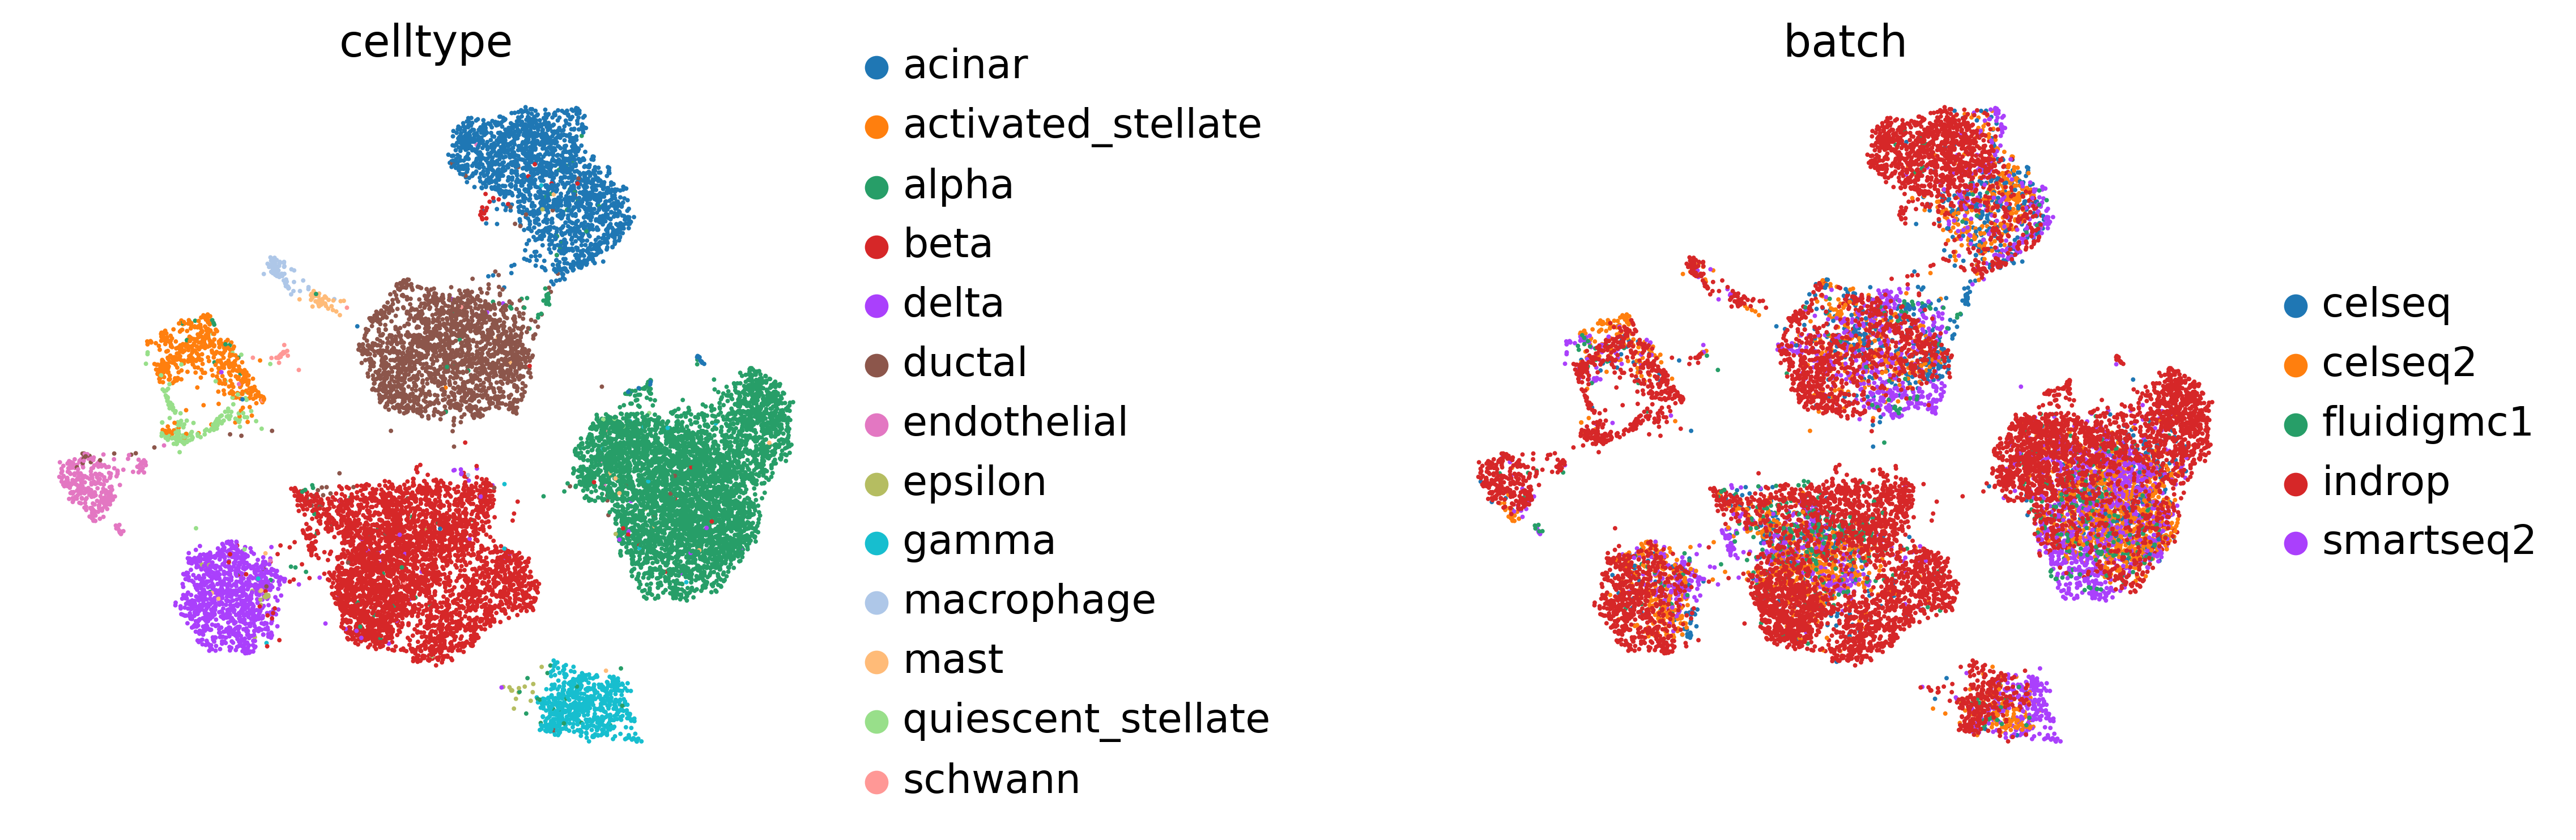

In [13]:
## 绘制整合后的UMAP图
ccVAE_eval.plot_latent(show=True,
                       save=False,
                       dir_path=None)

In [14]:
## save
outdir = './Benmarking/reproducibility/panc8_all/'
method = 'ccVAE_'
os.makedirs(outdir, exist_ok=True)

In [15]:
## 保存 X + latent 数据
import anndata as ad

# Concatenate the two AnnData objects
merged_adata = ad.concat([source_adata, target_adata], join='outer')
merged_adata.obsm = ccVAE_eval.adata_latent.obsm.copy()

## 保存数据
merged_adata.write(outdir+method+'adata.h5ad', compression='gzip') 

In [16]:
## 保存 latent 数据
ccVAE_eval.adata_latent.write(outdir+method+'adata_latent.h5ad', compression='gzip') 

In [17]:
## 保存模型
surg_path = 'model'
ccvae.save(outdir+method+surg_path, overwrite=True)

### Add celltype mode

In [18]:
from ccvae.step2_run_ccVAE import CCVAE

### Create TRVAE model and train it on reference dataset
ccvae = CCVAE(
    adata_ccPairs=source_adata,
    adata_rest=target_adata,
    #use_mmd = False,
    condition_key=condition_key,
    conditions=source_conditions,
    cell_type_key=cell_type_key,
    hidden_layer_sizes=[128, 128],
    recon_loss=['mse','mse'],
    mmd_on = 'z',
)


INITIALIZING THE WHOLE CCVAE NETWORK..............

Initializing ccVAE SubNetwork(trVAE) for ccPairs cells:
Encoder Sub-Architecture of ccPairs cells:
	Input Layer in, out and cond: 3126 128 5
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10

Decoder Sub-Architecture of ccPairs cells:
	First Layer in, out and cond:  10 128 5
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 3126 


Initializing ccVAE SubNetwork(CVAE) for batch-free cells:
Encoder Sub-Architecture of rest cells:
	Input Layer in, out and cond: 3126 128 5
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10

Decoder Sub-Architecture of rest cells:
	First Layer in, out and cond:  10 128 5
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 3126 



In [19]:
ccvae.train(
    n_epochs=ccvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    monitor_only_val = False,
    #train_frac = 0.8
)

Preparing (4525, 3126) for ccPairs cells
Instantiating dataset of ccPairs cells
Preparing (10365, 3126) for rest cells
Instantiating dataset of rest cells


/data2/zhouwg/Pytorch_study/algorithm_dev/ccvae/step2_ccVAE_loss.py:292: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm_(Tensor mat1, Tensor mat2, *, Number beta, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  distmat.addmm_(1, -2, x, centers.t())


 |███-----------------| 15.0%  - epoch_loss: 259.1890707016 - epoch_recon_loss: 121.8697814941 - epoch_kl_loss: 22.1671213508 - epoch_ccPairs_loss: 48.8045229912 - epoch_rest_loss: 73.0652585030 - epoch_center_loss: 0.1809857315 - epoch_ccPairs_center_loss: 0.0856026458 - epoch_rest_center_loss: 0.0953830872 - epoch_mmd_loss: 6.8857031465 - val_loss: 329.0550384521 - val_recon_loss: 148.5541000366 - val_kl_loss: 21.7677087784 - val_ccPairs_loss: 50.0477762222 - val_rest_loss: 98.5063247681 - val_center_loss: 0.1763267741 - val_ccPairs_center_loss: 0.0707901493 - val_rest_center_loss: 0.1055366341 - val_mmd_loss: 23.540116310118
ADJUSTED LR
 |███-----------------| 16.4%  - epoch_loss: 254.0551161766 - epoch_recon_loss: 119.0514454842 - epoch_kl_loss: 21.9351514578 - epoch_ccPairs_loss: 47.7373223305 - epoch_rest_loss: 71.3141245842 - epoch_center_loss: 0.1835561814 - epoch_ccPairs_center_loss: 0.0871768524 - epoch_rest_center_loss: 0.0963793295 - epoch_mmd_loss: 6.7013733983 - val_loss:

In [20]:
from ccvae.step3_ccVAE_evaluation import CCVAE_EVAL

### Create anndata file of latent representation and compute UMAP
adata_latent = sc.AnnData(ccvae.get_latent())

ccVAE_eval = CCVAE_EVAL(adata_latent=adata_latent,
                       adata_ccPairs=source_adata,
                       adata_rest=target_adata,
                       condition_key=condition_key,
                       cell_type_key=cell_type_key,
                       n_neighbors=8)

/home/zhouwg/anaconda3/envs/PyTorch/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/zhouwg/anaconda3/envs/PyTorch/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/zhouwg/anaconda3/envs/PyTorch/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


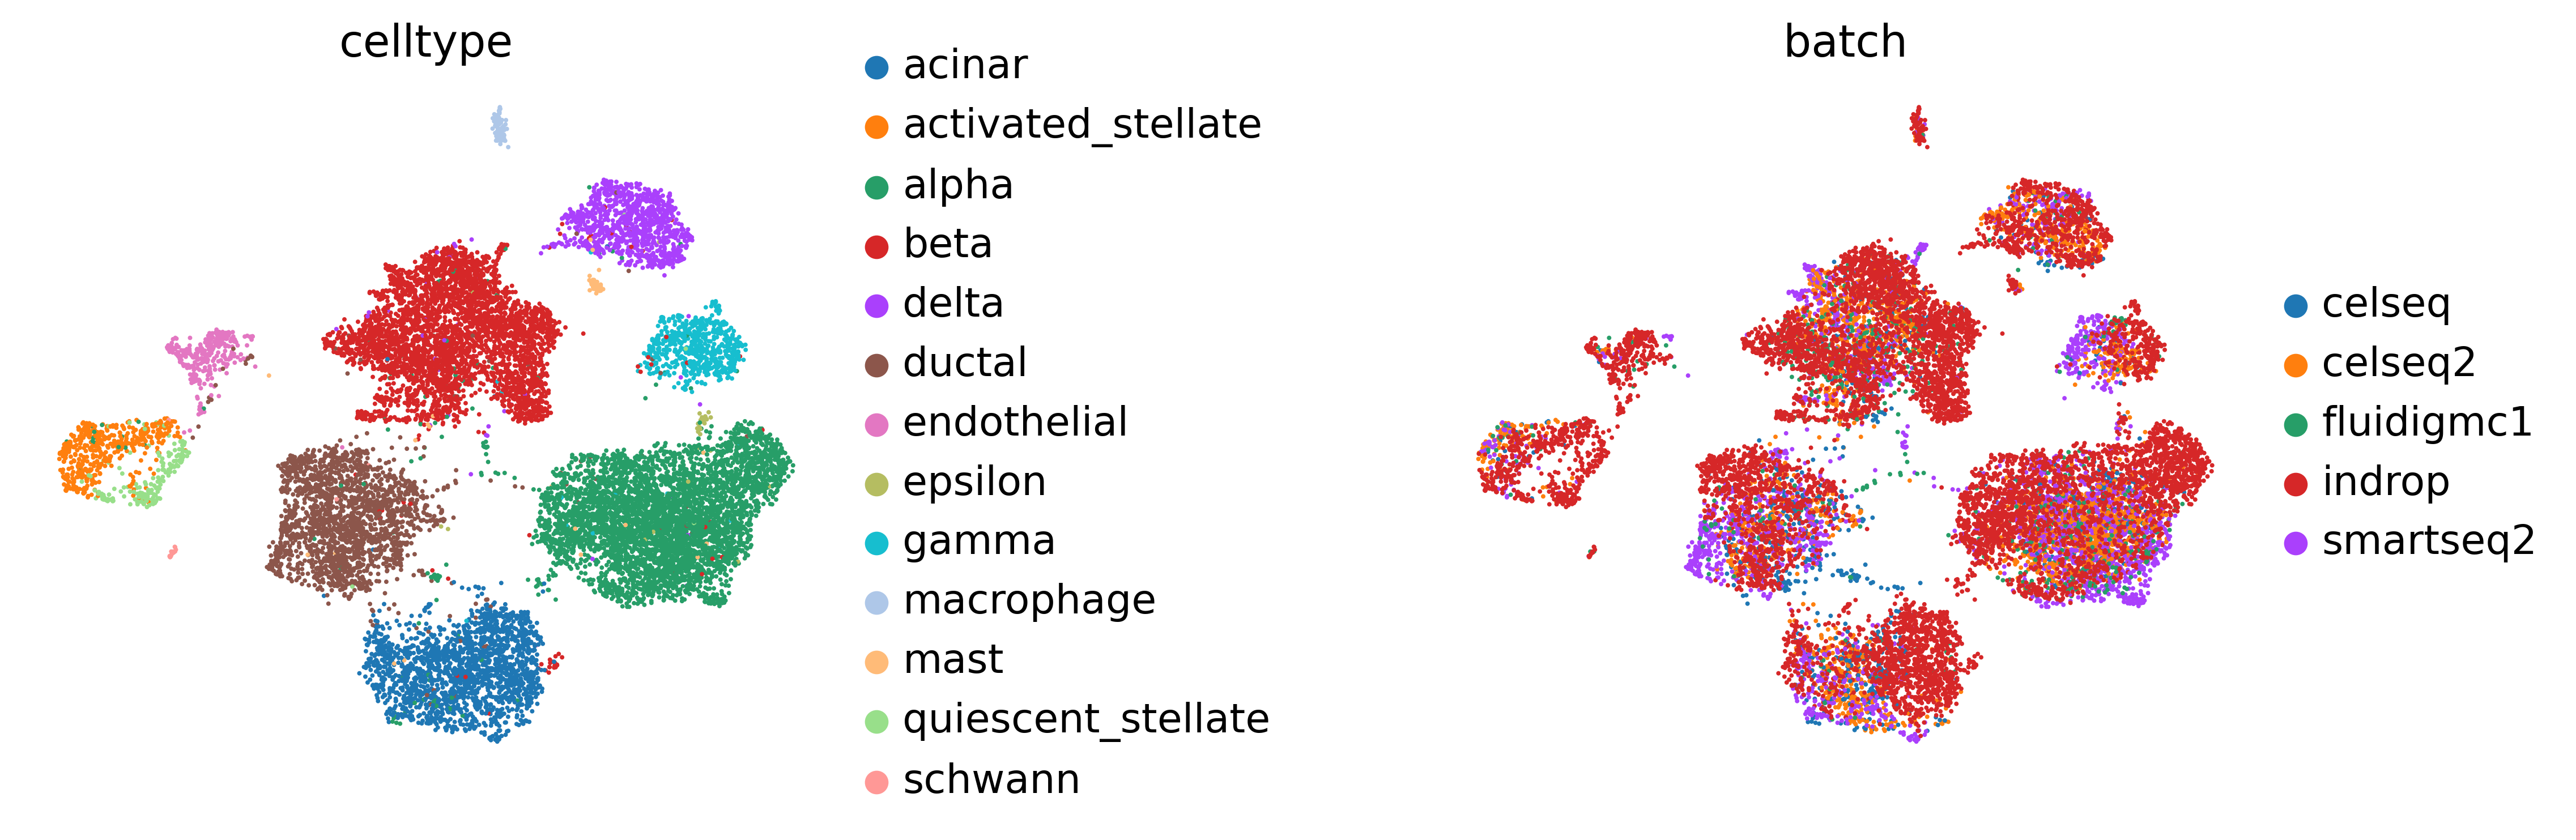

In [21]:
## 绘制整合后的UMAP图
ccVAE_eval.plot_latent(show=True,
                       save=False,
                       dir_path=None)

In [22]:
## 新建文件夹
outdir = './Benmarking/reproducibility/panc8_all/'
method = 'ccVAE_'
os.makedirs(outdir, exist_ok=True)

In [23]:
## 保存 X + latent 数据
import anndata as ad

# Concatenate the two AnnData objects
merged_adata = ad.concat([source_adata, target_adata], join='outer')
merged_adata.obsm = ccVAE_eval.adata_latent.obsm.copy()

## 保存数据
merged_adata.write(outdir+method+'adata_celltype.h5ad', compression='gzip') 

In [24]:
## 保存 latent 数据
ccVAE_eval.adata_latent.write(outdir+method+'adata_latent_celltype.h5ad', compression='gzip') 

In [25]:
## 保存模型
surg_path = 'model_celltype'
ccvae.save(outdir+method+surg_path, overwrite=True)